In [22]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds


In [10]:
[train_ds, test_ds], ds_info = tfds.load(
    "cars196",
    split=["train", "test"],
    as_supervised=True,
    with_info=True,
    download=True,
)

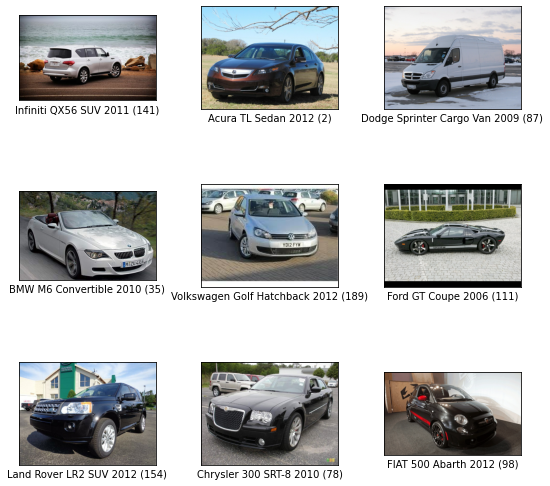

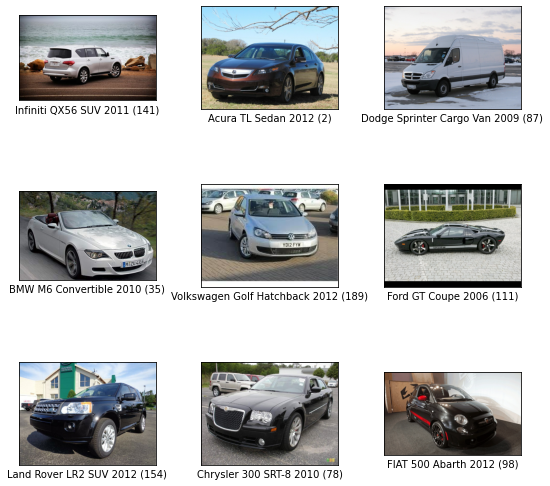

In [18]:
tfds.visualization.show_examples(test_ds, ds_info)

In [19]:
height, width = 150, 150
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [20]:
batch_size = 32


def augment_func(image,label):
    image = tf.image.resize_with_crop_or_pad(image,height+6,width+6)
    image = tf.image.random_crop(image, size=[height, width, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 2)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label

train_ds = train_ds.cache().map(augment_func).shuffle(100).batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [24]:
ImageNetModel = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(height, width, 3),
    include_top=False, # Do not include the final ImageNet classifier layer at the top.
) 

ImageNetModel.trainable = True #


inputs = tf.keras.Input(shape=(height, width, 3))

norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(inputs)
norm_layer.set_weights([mean, var])

x = ImageNetModel(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
num_outputs = ds_info.features['label'].num_classes
outputs = keras.layers.Dense(num_outputs, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
normalization_1 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               401604    
Total params: 21,263,091
Trainable params: 21,208,556
Non-trainable params: 54,535
_____________________________________

In [ ]:
learning_rate = 5.0e-5

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=test_ds)
model.save()

Epoch 1/100
138/255 [===============>..............] - ETA: 6:20 - loss: 5.2876 - sparse_categorical_accuracy: 0.0072